---
title: "Analysis of Customer Survey for Meddibia"
subtitle: "Meddibia Market Analysis"
author: "Tony Kabilan Okeke"
format:
  html:
    code-fold: true
  PrettyPDF-pdf:
    code-fold: true 
---

In [1]:
#| echo: false

%load_ext autoreload
%autoreload 2

import tools

In [2]:
#| echo: false

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import rich

from pathlib import Path

ROOT = Path(__name__).resolve().parent.parent
DATA = ROOT/"data"

df = pd.read_csv(DATA/"05142024-interest-form-responses.csv").drop(
    columns=["Timestamp", "Email Address"]
)

## Response Demographics

In [3]:
#| echo: false

n_respondents = df.shape[0]
rich.print(f"Number of respondents: {n_respondents}")

Number of respondents: 65

## Question-by-Question Breakdown

### Q1: "What is your role at the hospital?"

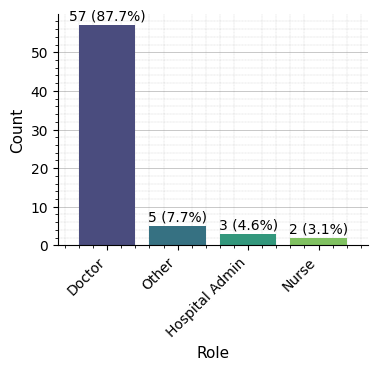

In [37]:
#| echo: false
#| fig-align: center
#| fig-cap: "Distribution of Hospital Roles among Respondents"

r = df.iloc[:, 0]
role_indices = r.str.get_dummies(sep=', ')
role_indices.columns = role_indices.columns.str.strip()

roi = ['Doctor', 'Nurse', 'Hospital Admin']  
role_indices = role_indices.rename(columns={
    'Head of Department': 'Hospital Admin',
    'Consultant obstetrician and gynaecologist': 'Doctor',
    'Hospital Administrator': 'Hospital Admin',
})

# Aggregate columns with the same name using the OR operation
for role in roi:
    if role in role_indices.columns:
        role_indices[role] = role_indices.filter(like=role).any(axis=1).astype(int)

# Drop the original columns that were aggregated
role_indices = role_indices.loc[:, ~role_indices.columns.duplicated()]

# Aggregate the columns of role_indices (except 'Doctor', 'Nurse', 'Hospital Admin') into a single column 'Other'
other_roles = role_indices.columns.difference(['Doctor', 'Nurse', 'Hospital Admin'])
role_indices['Other'] = role_indices[other_roles].any(axis=1).astype(int)

# Drop the original columns that were aggregated into 'Other'
role_indices = role_indices.drop(columns=other_roles)

# Count the number of respondents for each role
role_counts = role_indices.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(4,3))
tools.style_axis(ax, "role", "count")
sns.barplot(
    x=role_counts.index, 
    y=role_counts.values, 
    hue=role_counts.index,
    palette="viridis", 
    zorder=2,
    ax=ax
)
for i in range(len(role_counts)):
    pct = role_counts.values[i] / n_respondents * 100
    ax.text(i, role_counts.values[i] + 0.5, f"{role_counts.values[i]} ({pct:.1f}%)", ha='center', va='bottom')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(role_counts.index, rotation=45, ha='right', va='top')
ax.set_xlim(-0.7, len(role_counts) - 0.3);

### Q2: "How does your current medical record system impact daily operations at the hospital?"

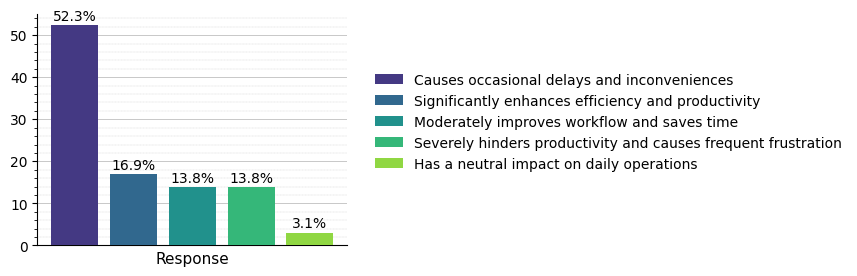

In [57]:
#| echo: false
#| fig-align: center
#| fig-cap: "Impact of Current MR solutions"

r = df.iloc[:, 1]
q2 = r.str.get_dummies(sep=', ')
q2.columns = q2.columns.str.strip()
q2 = (q2.sum() / q2.sum(axis=0).sum(axis=0) * 100).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(4,3))
tools.style_axis(ax, "Response", "")

pal = sns.color_palette('viridis', len(q2))
bars = ax.bar(q2.index, q2.values, color=pal, zorder=3)
ax.set_xticks([])
ax.legend(bars, q2.index, bbox_to_anchor=(1.05, 0.8), loc='upper left', frameon=False)
for i in range(len(q2)):
    ax.text(i, q2.values[i] + 0.5, f"{q2.values[i]:.1f}%", ha='center', va='bottom')

In [65]:
#| echo: false

# positie 
pans = [
    'Significantly enhances efficiency and productivity', 
    'Moderately improves workflow and saves time'
]
nans = [
    'Causes occasional delays and inconveniences',
    'Severely hinders productivity and causes frequent frustration'
]

positive = q2[pans].sum()
negative = q2[nans].sum()

rich.print(f"""\
MR has positive impact on daily operations: {positive:.1f}%
MR has negative impact on daily operations: {negative:.1f}%
""")



MR has positive impact on daily operations: 30.8%
MR has negative impact on daily operations: 66.2%

In [95]:
#| echo: false
#| fig-align: center
#| fig-cap: "EMR Type for each Impact Level"

p_df = df.loc[r.isin(pans)]
gcol = "How does your current medical record system impact daily operations at the hospital?"
col = "What type of medical record system do you currently use?"

result = df.groupby(gcol)[col].value_counts().unstack()
result.style.format("{:.0f}").background_gradient(cmap='Reds').set_properties(**{'text-align': 'center'})

What type of medical record system do you currently use?,Electronic (EMR/EHR),Hybrid (paper & electronic),Paper-based
How does your current medical record system impact daily operations at the hospital?,,,
Causes occasional delays and inconveniences,8,10,16
Has a neutral impact on daily operations,2,nan,nan
Moderately improves workflow and saves time,1,4,4
Severely hinders productivity and causes frequent frustration,nan,5,4
Significantly enhances efficiency and productivity,7,3,1


### Q3: "On a scale of 1-5, how satisfied are you with your current medical record system?"

![Q3 Results](figures/google-q3.png)


### Q4: "What type of medical record system do you currently use?"

![Q4](figures/google-q4.png)

### Q5: "What are the key challenges you face with the existing record-keeping process?"

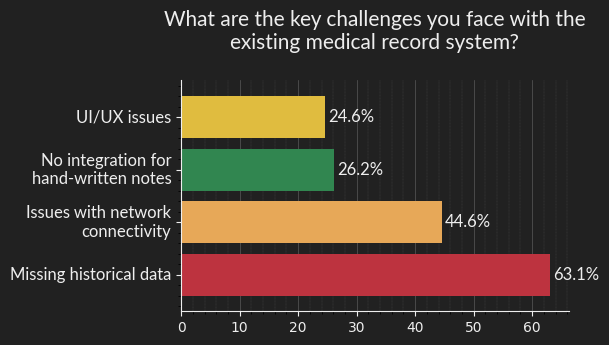

In [107]:
remap = {
    "Incomplete patient records": "Missing historical data",
    "Delays due to poor network": "Issues with network\nconnectivity",
    "Inability to view surgery notes": "No integration for\nhand-written notes",
    "User interface is not intuitive": "UI/UX issues"
}
ans = df.iloc[:, 4]
ohans = ans.str.get_dummies(", ")[list(remap)].sum() / ans.shape[0] * 100
ohans = ohans.rename(remap)

question = "What are the key challenges you face with the\nexisting medical record system?\n"

fig, ax = plt.subplots(figsize=(5, 3))
fig.patch.set_facecolor('#212121ff')
ax.set_facecolor('#212121ff')
tools.style_axis(ax, ygrid=False)

# Set axes lines and ticks color to #eeeeee
ax.tick_params(colors='#eeeeee')
for spine in ax.spines.values():
    spine.set_edgecolor('#eeeeee')

sns.barplot(
    x=ohans.values, 
    y=ohans.index, 
    hue=ohans.index,
    palette=["#d41c2c", "#ffab40", "#23944c", "#fbcb24"], 
    zorder=2,
    ax=ax,
    orient='h'
)
for i in range(len(ohans)):
    pct = ohans.values[i]
    ax.text(ohans.values[i] + 0.5, i, f"{ohans.values[i]:.1f}%", ha='left', va='center', fontname='Lato', color='#eeeeee', fontsize=12)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ohans.index, ha='right', va='center', fontname='Lato', fontsize=12)
ax.set_ylim(-0.7, len(ohans) - 0.3)
ax.set_ylabel('', fontname='Lato')
ax.set_title(question, fontname='Lato', fontsize=15, color='#eeeeee')

plt.savefig("figures/google-q5.png", dpi=300, bbox_inches='tight')



### Q6: "Can you share a recent example where the current system caused difficulties in patient care?"

In [ ]:
# summarize with gpt

### Q7: "On a scale of 1-5, how often do you encounter issues with your current medical record system?"

### Q8: "Have you explored or considered any alternative solutions to improve your medical record system?"

### Q8a: "If yes, what solutions have you considered?"

In [ ]:

# summarize with gpt

### Q9: "What factors are important to you when considering a new system for the hospital?"

In [ ]:

# summarize with gpt

### Q10: "On a scale of 1-5, how critical do you consider the need for a more advanced medical record system in your hospital?"

### Q10a: "Why do you feel this way?"

In [ ]:

# summarize with gpt - include Q10 answer

### Q11: "What features would you like to see in an ideal electronic medical record system?"

### Q12:"What concerns do you have about adopting a new EMR system?"

### Q13: "How do you perceive the costs associated with upgrading to a modern electronic record system?"

### Q14: "How much time would you be willing to invest in training your staff to use a new EMR system?"

### Q15: "Is there anything else you would like to share about challenges you've faced with your hospital's current record-keeping system?"

#